# DM2024-Lab2-Homework Part2
- Name: 黃大展
- Student ID: 113030515
- GitHub ID: DanielHuang0206
- Kaggle name: dc0206
- Kaggle private scoreboard snapshot: 

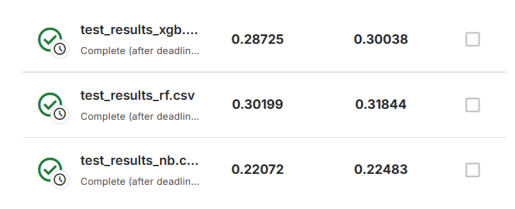

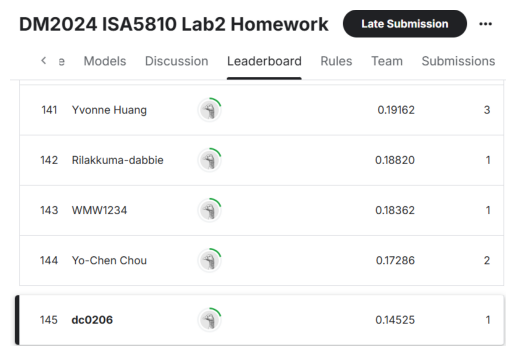

Too late tp upload my new result......


In [15]:
image_path_1 = "/home/dc0206/DM2024-Lab2-Master/HW/F1.png"
image_path_2 = "/home/dc0206/DM2024-Lab2-Master/HW/Rank.png"
import matplotlib.image as mpimg
img_1 = mpimg.imread(image_path_1)
plt.imshow(img_1)
plt.axis('off')  
plt.show()
img_2 = mpimg.imread(image_path_2)
plt.imshow(img_2)
plt.axis('off')  
plt.show()
print("Too late tp upload my new result......")


# 數據處理,Feature Engineering:
我的數據是在筆電(windows)上跑的，這段程式我把訓練和測試資料分開，從留言的_source 欄位中提取內容（ tweet_id、hashtags 和 text），組成新的 DataFrame。並整合data_identification 和 emotion，再把缺實值補unknow(但好像多此一舉)，最後輸出成檔案。

In [ ]:
import pandas as pd
import json

# 定義檔案路徑
paths = {
    "split": r"C:\Users\user\Desktop\lab2\data_identification.csv",
    "emotion": r"C:\Users\user\Desktop\lab2\emotion.csv",
    "tweets": r"C:\Users\user\Desktop\lab2\tweets_DM.json",
    "train_output": r"C:\Users\user\Desktop\lab2\processed_train.csv",
    "test_output": r"C:\Users\user\Desktop\lab2\processed_test.csv",
}

def load_csv(path, description):
  
    try:
        data = pd.read_csv(path, on_bad_lines="skip")
        print(f"成功載入 {description}: {data.shape}")
        return data
    except Exception as e:
        raise ValueError(f"載入 {description} 出錯: {e}")

def load_json_lines(path):
  
    tweets_list = []
    with open(path, 'r') as file:
        for line in file:
            try:
                tweets_list.append(json.loads(line))
            except json.JSONDecodeError:
                print(f"跳過: {line.strip()}")
    print(f"成功載入 tweets_data: {len(tweets_list)} 行")
    return pd.DataFrame(tweets_list)

data_identification = load_csv(paths["split"], "data_identification")
emotion_data = load_csv(paths["emotion"], "emotion_data")
tweets_data = load_json_lines(paths["tweets"])

tweets_data['_source'] = tweets_data['_source'].apply(lambda x: x['tweet'] if 'tweet' in x else {})
df = pd.DataFrame({
    'tweet_id': tweets_data['_source'].apply(lambda x: x.get('tweet_id', None)),
    'hashtags': tweets_data['_source'].apply(lambda x: x.get('hashtags', [])),
    'text': tweets_data['_source'].apply(lambda x: x.get('text', "")),
})
print(f"成功提取 tweet 資料: {df.shape}")

df = df.merge(data_identification, on="tweet_id", how="left")
df = df.merge(emotion_data, on="tweet_id", how="left")
print(f"合併資料後的SHAPE: {df.shape}")


df['emotion'] = df['emotion'].fillna('unknown')

train_data = df[df['identification'] == 'train']
test_data = df[df['identification'] == 'test']

test_data = test_data[['tweet_id', 'hashtags', 'text', 'identification']]

train_data.to_csv(paths["train_output"], index=False)
test_data.to_csv(paths["test_output"], index=False)


# XGBoost
這邊採用XGBoost(因為查到他是kaggle常勝軍)，這邊抽樣6000筆資料，採用TFIDF，並且把Train分割成80:20作為訓練及驗證

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

train_path = '/home/dc0206/Desktop/3.9.20/DM/processed_train.csv'
test_path = '/home/dc0206/Desktop/3.9.20/DM/test000.csv'
output_dir = '/home/dc0206/Desktop/3.9.20/DM'

os.makedirs(output_dir, exist_ok=True)

sample_size = 6000  
train_data = pd.read_csv(train_path, engine='python', on_bad_lines='skip').sample(n=sample_size, random_state=42)

train_data['text'] = train_data['text'].fillna("")
train_data['emotion'] = train_data['emotion'].fillna("unknown")

label_encoder = LabelEncoder()
train_data['label_encoded'] = label_encoder.fit_transform(train_data['emotion'])

tfidf_vectorizer = TfidfVectorizer(
    max_features=4000,  
    stop_words='english',  
    ngram_range=(1, 2)  
)
X_train = tfidf_vectorizer.fit_transform(train_data['text'])
y_train = train_data['label_encoded']


test_data = pd.read_csv(test_path, engine='python', on_bad_lines='skip')
test_data['text'] = test_data['text'].fillna("")
X_test = tfidf_vectorizer.transform(test_data['text'])

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train_split = X_train_split.toarray()
X_val_split = X_val_split.toarray()
X_test = X_test.toarray()

xgb_model = xgb.XGBClassifier(
    tree_method='hist',  
    device='cuda',       
    random_state=42
)


param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1_weighted', 
    cv=3,
    verbose=2,
    n_jobs=-1
)


grid_search.fit(X_train_split, y_train_split)
print("最佳:", grid_search.best_params_)

optimized_xgb = grid_search.best_estimator_
optimized_xgb.fit(X_train_split, y_train_split)
y_val_pred = optimized_xgb.predict(X_val_split)
val_f1 = f1_score(y_val_split, y_val_pred, average='weighted')
print(f"F1: {val_f1:.4f}")

y_test_pred = optimized_xgb.predict(X_test)
predicted_labels = label_encoder.inverse_transform(y_test_pred)

output_file = os.path.join(output_dir, "final_submission_xgb.csv")
test_data['predicted_emotion'] = predicted_labels
test_data[['tweet_id', 'predicted_emotion']].to_csv(output_file, index=False)
print(f"结果已保存: {output_file}")

if 'emotion' in test_data.columns:
    true_labels = label_encoder.transform(test_data['emotion'])
    print("\n class report:")
    print(classification_report(true_labels, y_test_pred, target_names=label_encoder.classes_))

    
    conf_matrix = confusion_matrix(true_labels, y_test_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix for XGBoost")
    conf_matrix_file = os.path.join(output_dir, "confusion_matrix_xgb.png")
    plt.savefig(conf_matrix_file)
    plt.close()
    print(f"混淆: {conf_matrix_file}")


Fitting 3 folds for each of 24 candidates, totalling 72 fits


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:54:08] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=  39.9s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:54:09] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=  40.5s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:54:09] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:54:09] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster

[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=  40.8s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=  40.9s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:54:10] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=  41.3s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:54:11] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=  42.0s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:54:19] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=  50.9s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:54:20] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:54:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster

[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=  51.7s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=  51.9s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:54:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=  52.7s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:54:49] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time= 1.3min


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:54:51] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time= 1.4min


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:54:52] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time= 1.4min


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:54:53] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:54:53] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster

[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time= 1.4min
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time= 1.4min


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:54:53] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time= 1.4min
[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=  51.2s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=  53.3s
[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time= 1.1min
[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time= 1.1min
[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time= 1.1min
[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time= 1.2min
[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time= 1.2min
[CV] END learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time= 1.9min
[CV] END learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time= 1.9min
[CV] END learning_rate=0.01, max_depth=7, n_estimators=100, 

/home/dc0206/pytorch_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time= 2.2min
[CV] END learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time= 1.5min
[CV] END learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time= 1.5min
[CV] END learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time= 1.4min
[CV] END learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time= 2.1min
[CV] END learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time= 1.5min
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=  53.9s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=  53.4s
[CV] END learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time= 2.2min
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=  55.1s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, subsampl

/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:58:44] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time= 1.1min
[CV] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time= 1.1min


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:58:59] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time= 1.7min
[CV] END learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time= 1.7min
[CV] END learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time= 1.6min
[CV] END learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time= 1.6min
[CV] END learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time= 1.7min


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:59:10] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time= 1.6min
[CV] END learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time= 1.5min


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:59:28] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time= 1.5min
[CV] END learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time= 1.3min
[CV] END learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time= 1.4min
[CV] END learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=  51.6s
[CV] END learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=  51.3s
最佳: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:59:44] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


F1: 0.3997


XGBoostError: [02:59:48] /workspace/src/c_api/../common/device_helpers.cuh:393: Memory allocation error on worker 0: std::bad_alloc: cudaErrorMemoryAllocation: out of memory
- Free memory: 12638224384
- Requested memory: 13183104000

Stack trace:
  [bt] (0) /home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x22dcbc) [0x75b1a9e2dcbc]
  [bt] (1) /home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x8a9886) [0x75b1aa4a9886]
  [bt] (2) /home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0xe938c) [0x75b1a9ce938c]
  [bt] (3) /home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x8fb29c) [0x75b1aa4fb29c]
  [bt] (4) /home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x926d66) [0x75b1aa526d66]
  [bt] (5) /home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0xca36cb) [0x75b1aa8a36cb]
  [bt] (6) /home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x57be18) [0x75b1aa17be18]
  [bt] (7) /home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x57c1e0) [0x75b1aa17c1e0]
  [bt] (8) /home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x5d0389) [0x75b1aa1d0389]



# rf

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

train_path = '/home/dc0206/Desktop/3.9.20/DM/processed_train.csv'
test_path = '/home/dc0206/Desktop/3.9.20/DM/test000.csv'
output_dir = '/home/dc0206/Desktop/3.9.20/DM'

os.makedirs(output_dir, exist_ok=True)


sample_size = 6000  
train_data = pd.read_csv(train_path, engine='python', on_bad_lines='skip').sample(n=sample_size, random_state=42)
test_data = pd.read_csv(test_path, engine='python', on_bad_lines='skip')


train_data['text'] = train_data['text'].fillna("")
train_data['emotion'] = train_data['emotion'].fillna("unknown")


label_encoder = LabelEncoder()
train_data['label_encoded'] = label_encoder.fit_transform(train_data['emotion'])

tfidf_vectorizer = TfidfVectorizer(
    max_features=4000,  
    stop_words='english',  
    ngram_range=(1, 2)  
)
X_train = tfidf_vectorizer.fit_transform(train_data['text'])
y_train = train_data['label_encoded']


test_data['text'] = test_data['text'].fillna("")
X_test = tfidf_vectorizer.transform(test_data['text'])


X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


X_train_split = X_train_split.toarray()
X_val_split = X_val_split.toarray()
X_test = X_test.toarray()

rf_model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='f1_weighted',  
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_split, y_train_split)
print("最佳:", grid_search.best_params_)

optimized_rf = grid_search.best_estimator_
optimized_rf.fit(X_train_split, y_train_split)


y_val_pred = optimized_rf.predict(X_val_split)
val_f1 = f1_score(y_val_split, y_val_pred, average='weighted')
print(f"F1: {val_f1:.4f}")


y_test_pred = optimized_rf.predict(X_test)
predicted_labels = label_encoder.inverse_transform(y_test_pred)


test_data['predicted_emotion'] = predicted_labels
test_output_file = os.path.join(output_dir, "test_results_rf.csv")
test_data[['tweet_id', 'predicted_emotion']].to_csv(test_output_file, index=False)
print(f"結果已保存: {test_output_file}")


if 'emotion' in test_data.columns:
    true_labels = label_encoder.transform(test_data['emotion'])
    class_report = classification_report(true_labels, y_test_pred, target_names=label_encoder.classes_)
    report_file = os.path.join(output_dir, "classification_report_rf.txt")
    with open(report_file, "w") as f:
        f.write(class_report)
    print(f"報告已保存: {report_file}")

    conf_matrix = confusion_matrix(true_labels, y_test_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix for Random Forest")
    conf_matrix_file = os.path.join(output_dir, "confusion_matrix_rf.png")
    plt.savefig(conf_matrix_file)
    plt.close()
    print(f"混淆: {conf_matrix_file}")


Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.6s
[

# XGB with attention to catch feature

In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

train_path = '/home/dc0206/Desktop/3.9.20/DM/processed_train.csv'
test_path = '/home/dc0206/Desktop/3.9.20/DM/test000.csv'
output_dir = '/home/dc0206/Desktop/3.9.20/DM'

os.makedirs(output_dir, exist_ok=True)

sample_size = 6000
train_data = pd.read_csv(train_path, engine='python', on_bad_lines='skip').sample(n=sample_size, random_state=42)
test_data = pd.read_csv(test_path, engine='python', on_bad_lines='skip')

train_data['text'] = train_data['text'].fillna("")
train_data['emotion'] = train_data['emotion'].fillna("unknown")

label_encoder = LabelEncoder()
train_data['label_encoded'] = label_encoder.fit_transform(train_data['emotion'])

tfidf_vectorizer = TfidfVectorizer(
    max_features=4000,
    stop_words='english',
    ngram_range=(1, 2)
)
X_train = tfidf_vectorizer.fit_transform(train_data['text'])
y_train = train_data['label_encoded']

test_data['text'] = test_data['text'].fillna("")
X_test = tfidf_vectorizer.transform(test_data['text'])

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train_split = X_train_split.toarray()
X_val_split = X_val_split.toarray()
X_test = X_test.toarray()

xgb_model = xgb.XGBClassifier(
    tree_method='hist',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_split, y_train_split)
print("最佳:", grid_search.best_params_)

optimized_xgb = grid_search.best_estimator_
optimized_xgb.fit(X_train_split, y_train_split)

y_val_pred = optimized_xgb.predict(X_val_split)
val_f1 = f1_score(y_val_split, y_val_pred, average='weighted')
print(f"F1: {val_f1:.4f}")

y_test_pred = optimized_xgb.predict(X_test)
predicted_labels = label_encoder.inverse_transform(y_test_pred)

test_data['predicted_emotion'] = predicted_labels
test_output_file = os.path.join(output_dir, "test_results_xgb.csv")
test_data[['tweet_id', 'predicted_emotion']].to_csv(test_output_file, index=False)
print(f"結果已保存: {test_output_file}")

if 'emotion' in test_data.columns:
    true_labels = label_encoder.transform(test_data['emotion'])
    class_report = classification_report(true_labels, y_test_pred, target_names=label_encoder.classes_)
    report_file = os.path.join(output_dir, "classification_report_xgb.txt")
    with open(report_file, "w") as f:
        f.write(class_report)
    print(f"class report: {report_file}")

    conf_matrix = confusion_matrix(true_labels, y_test_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix for XGBoost")
    conf_matrix_file = os.path.join(output_dir, "confusion_matrix_xgb.png")
    plt.savefig(conf_matrix_file)
    plt.close()
    print(f"混淆: {conf_matrix_file}")


Fitting 3 folds for each of 72 candidates, totalling 216 fits


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:23:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:23:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:23:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:23:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:23:57] WA

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=  10.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=  10.6s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=  10.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=  11.0s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=  11.2s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=  11.6s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=  20.3s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=  20.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=  21.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=  21.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=  21.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=  21.5s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=  11.1s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=  11.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=  11.6s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=  12.2s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=  30.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=  30.8s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=  31.2s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=  31.5s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=  11.6s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=  12.6s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=  29.1s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=  31.6s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=  23.0s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=  24.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=  24.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=  23.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=  23.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=  26.0s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=  14.4s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=  13.0s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:46] WA

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=  13.8s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=  13.5s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=  14.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=  35.4s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=  35.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=  14.0s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0; total time=  36.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0; total time=  36.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=  37.3s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0; total time=  36.8s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=  27.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=  27.4s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=  27.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=  28.2s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=  28.8s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=  28.7s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=  11.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=  11.6s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=  11.6s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=  11.7s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=  10.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=  11.0s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.8; total time=  40.7s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=  21.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=  22.2s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=  21.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.8; total time=  41.2s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=  20.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=  22.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.8; total time=  40.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=1.0; total time=  40.7s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=  21.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=1.0; total time=  39.6s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:37] WA

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=1.0; total time=  41.1s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=  11.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=  12.3s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=  12.2s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8; total time=  31.0s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=  12.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=  12.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=  12.6s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8; total time=  32.5s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8; total time=  31.4s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0; total time=  31.8s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:25:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=  23.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=  23.9s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=  24.3s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=  23.4s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0; total time=  30.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0; total time=  32.2s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=  13.5s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=  13.8s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=  23.5s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=  24.4s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=  13.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=  14.5s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=  13.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=  14.3s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8; total time=  36.1s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1.0; total time=  34.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1.0; total time=  35.6s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8; total time=  37.0s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8; total time=  36.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1.0; total time=  35.8s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=  26.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=  28.1s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=  26.6s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=  26.0s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=  10.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=  25.4s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=  11.6s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=  11.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=  26.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=  11.1s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=  10.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=  10.3s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.8; total time=  39.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=  20.5s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=1.0; total time=  37.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=  21.8s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=  21.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=  21.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.8; total time=  42.0s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=  21.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.8; total time=  40.7s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=  21.2s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=1.0; total time=  37.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=1.0; total time=  37.2s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=  11.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=  12.2s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=  12.2s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=  31.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=  12.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=  13.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=  31.6s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=  12.6s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=  31.4s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=  32.2s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=  23.9s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=  24.0s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=  31.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=  24.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=  25.1s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=  31.9s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=  13.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=  14.7s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=  23.6s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=  24.4s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=  14.4s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=  15.4s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=  14.4s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=  15.0s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=  37.2s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=  37.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0; total time=  36.8s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=  38.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0; total time=  38.4s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0; total time=  38.0s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=  27.6s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=  29.6s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=  28.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=  11.1s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=  30.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=  28.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=  27.9s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:27:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=  11.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=  11.9s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=  10.9s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=  12.1s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=  11.6s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.8; total time=  41.3s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.8; total time=  40.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=  20.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=  21.0s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.8; total time=  41.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=  22.7s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=  22.9s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=  21.9s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=  22.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=1.0; total time=  42.0s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=1.0; total time=  42.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=1.0; total time=  41.7s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=  11.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8; total time=  32.0s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8; total time=  32.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=  12.8s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=  12.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=  12.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=  12.9s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=  12.2s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0; total time=  31.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8; total time=  32.7s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=  24.2s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=  26.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0; total time=  31.0s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=  13.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=  13.6s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=  23.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0; total time=  32.6s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=  25.2s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=  23.6s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=  25.2s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:28:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=  14.3s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:29:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=  14.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=  14.4s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:29:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:29:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=  13.8s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:29:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8; total time=  36.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1.0; total time=  35.3s


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:29:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:29:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1.0; total time=  36.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8; total time=  37.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1.0; total time=  35.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8; total time=  38.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=  24.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=  24.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=  24.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8; total time=  27.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200,

/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:29:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


最佳: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}


/home/dc0206/pytorch_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:29:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1: 0.4124
結果已保存: /home/dc0206/Desktop/3.9.20/DM/test_results_xgb.csv


# naive_bayes
嘗試用multi是因為有查到他比較能處理不平衡的資料

In [11]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


train_path = '/home/dc0206/Desktop/3.9.20/DM/processed_train.csv'
test_path = '/home/dc0206/Desktop/3.9.20/DM/test000.csv'
output_dir = '/home/dc0206/Desktop/3.9.20/DM'
os.makedirs(output_dir, exist_ok=True)


sample_size = 7000
train_data = pd.read_csv(train_path, engine='python', on_bad_lines='skip').sample(n=sample_size, random_state=42)
test_data = pd.read_csv(test_path, engine='python', on_bad_lines='skip')
train_data['text'] = train_data['text'].fillna("")
train_data['emotion'] = train_data['emotion'].fillna("unknown")

label_encoder = LabelEncoder()
train_data['label_encoded'] = label_encoder.fit_transform(train_data['emotion'])

tfidf_vectorizer = TfidfVectorizer(
    max_features=8000,  
    stop_words='english',  
    ngram_range=(1, 4)  
)
X_train = tfidf_vectorizer.fit_transform(train_data['text'])
y_train = train_data['label_encoded']
test_data['text'] = test_data['text'].fillna("")
X_test = tfidf_vectorizer.transform(test_data['text'])
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
nb_model = MultinomialNB()

nb_model.fit(X_train_split, y_train_split)

y_val_pred = nb_model.predict(X_val_split)
val_f1 = f1_score(y_val_split, y_val_pred, average='weighted')
print(f"F1: {val_f1:.4f}")

y_test_pred = nb_model.predict(X_test)
predicted_labels = label_encoder.inverse_transform(y_test_pred)

test_data['predicted_emotion'] = predicted_labels
test_output_file = os.path.join(output_dir, "test_results_nb.csv")
test_data[['tweet_id', 'predicted_emotion']].to_csv(test_output_file, index=False)
print(f"结果已保存: {test_output_file}")


if 'emotion' in test_data.columns:
    true_labels = label_encoder.transform(test_data['emotion'])
    class_report = classification_report(true_labels, y_test_pred, target_names=label_encoder.classes_)
    report_file = os.path.join(output_dir, "classification_report_nb.txt")
    with open(report_file, "w") as f:
        f.write(class_report)
    print(f"class report: {report_file}")

    
    conf_matrix = confusion_matrix(true_labels, y_test_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix for Naive Bayes")
    conf_matrix_file = os.path.join(output_dir, "confusion_matrix_nb.png")
    plt.savefig(conf_matrix_file)
    plt.close()
    print(f"混淆: {conf_matrix_file}")


F1: 0.3186
结果已保存: /home/dc0206/Desktop/3.9.20/DM/test_results_nb.csv
